In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pingouin as pg
import joblib

from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import zscore
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

In [4]:
! pip install pingouin


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
df_salario = pd.read_csv('./dados/salario.csv')

In [6]:
df_salario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tempo_na_empresa  1000 non-null   int64  
 1   nivel_na_empresa  1000 non-null   int64  
 2   salario_em_reais  1000 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 23.6 KB


In [7]:
# Copiar DF para DF EDA
df_salario_eda = df_salario.copy()

In [8]:
# Copiar DF para DF Bucket
df_salario_bucketing = df_salario.copy()

EDA

In [9]:
# Visualizar os dados
df_salario_eda.head(10)

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
0,50,1,2288.13
1,49,4,2389.84
2,39,10,2158.73
3,51,1,2341.06
4,62,7,3584.20
5,105,10,12102.18
6,80,3,5723.35
7,85,2,6424.92
8,66,5,3916.18
9,73,5,4751.79


In [10]:
# Detectatar valores ausentes
df_salario_eda.isna().sum()

tempo_na_empresa    0
nivel_na_empresa    0
salario_em_reais    0
dtype: int64

In [11]:
# Medidas Estatísticas DF
df_salario_eda.describe()

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
count,1000.000000,1000.000000,1000.000000
mean,59.712000,5.467000,5093.726110
std,34.027679,2.889509,4536.168857
min,1.000000,1.000000,538.560000
25%,30.750000,3.000000,1537.477500
50%,60.000000,6.000000,3237.920000
75%,89.000000,8.000000,7436.680000
max,120.000000,10.000000,18923.230000


<Axes: xlabel='tempo_na_empresa'>

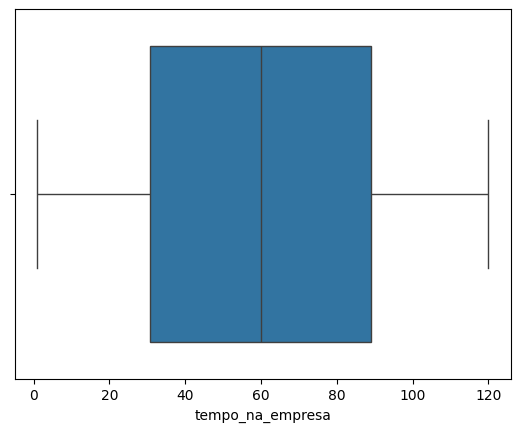

In [12]:
# Detectar outilier
sns.boxplot(df_salario_eda, x='tempo_na_empresa')

<Axes: xlabel='nivel_na_empresa'>

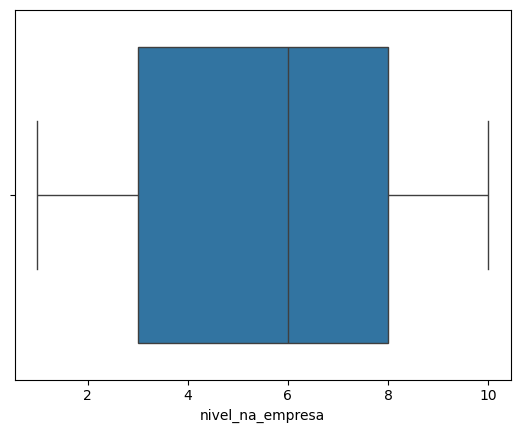

In [13]:
sns.boxplot(df_salario_eda, x='nivel_na_empresa')

<Axes: xlabel='salario_em_reais'>

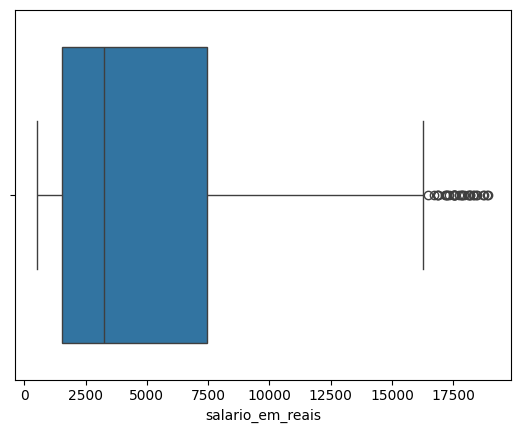

In [14]:
sns.boxplot(df_salario_eda, x='salario_em_reais')

<Axes: xlabel='tempo_na_empresa', ylabel='salario_em_reais'>

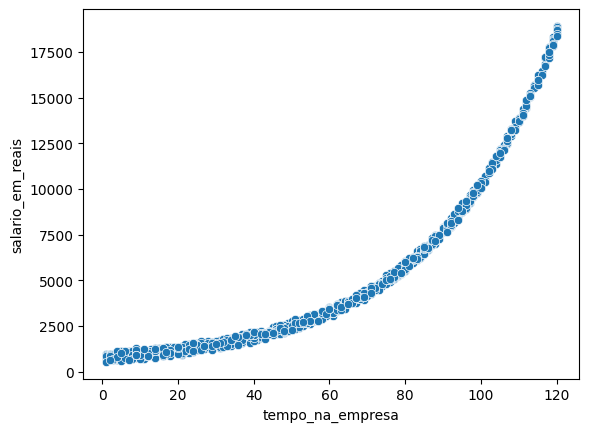

In [15]:
# Cruzamento de variáveis numéricas com salários em reais (variável independente)
sns.scatterplot(df_salario_eda, x='tempo_na_empresa', y='salario_em_reais')

<Axes: xlabel='nivel_na_empresa', ylabel='salario_em_reais'>

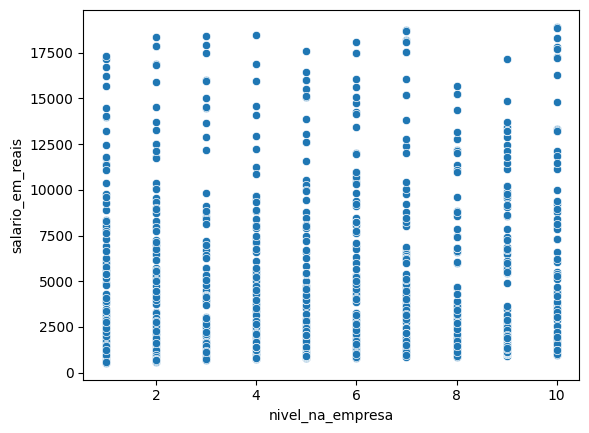

In [16]:
sns.scatterplot(data=df_salario_eda, x='nivel_na_empresa', y='salario_em_reais')

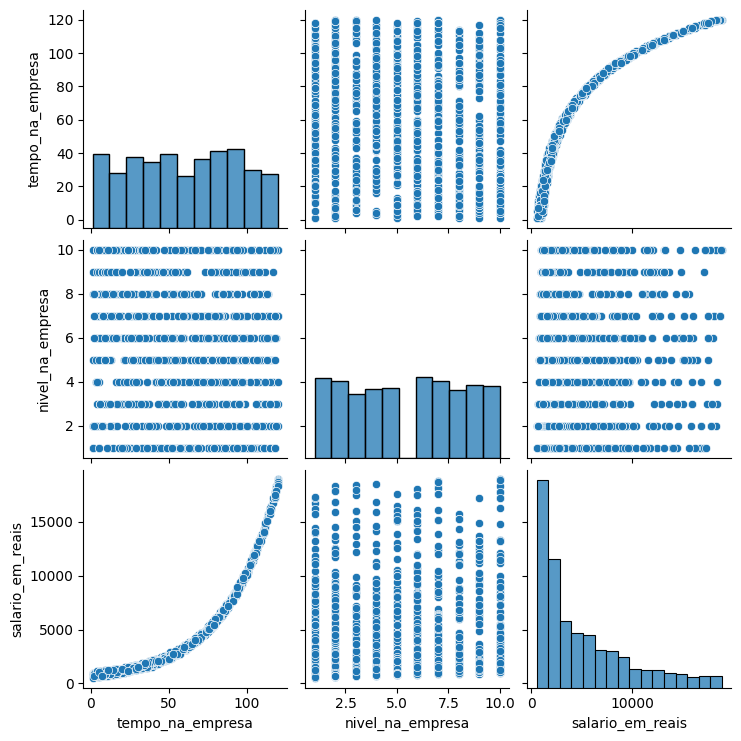

In [17]:
# Histograma das variáveis 
sns.pairplot(df_salario_eda)

<Axes: >

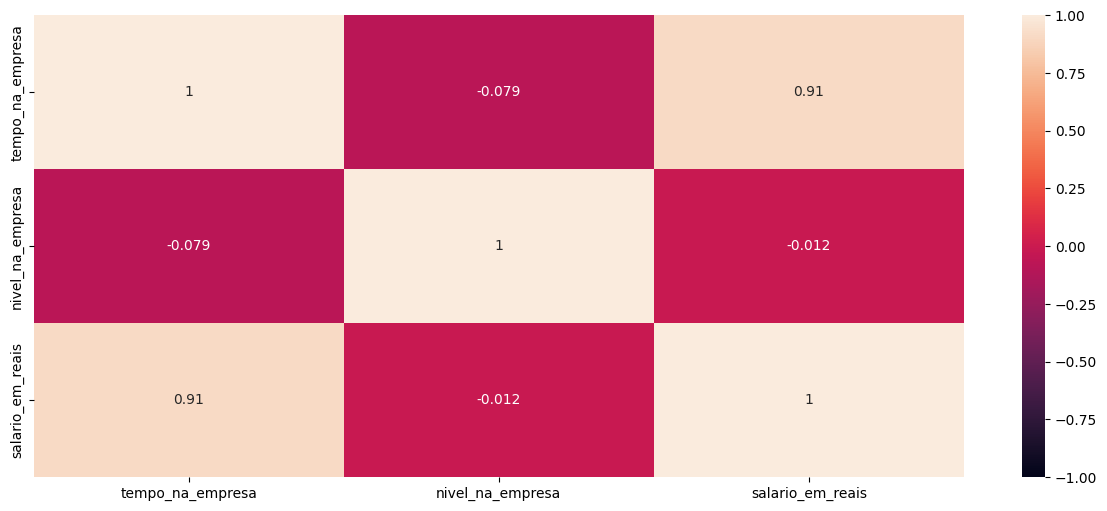

In [18]:
# Diagrama de correlação Mapa de Calor
plt.figure(figsize=(15, 6))
sns.heatmap(df_salario_eda.corr(), vmin=-1, vmax=1, annot=True)

<Axes: >

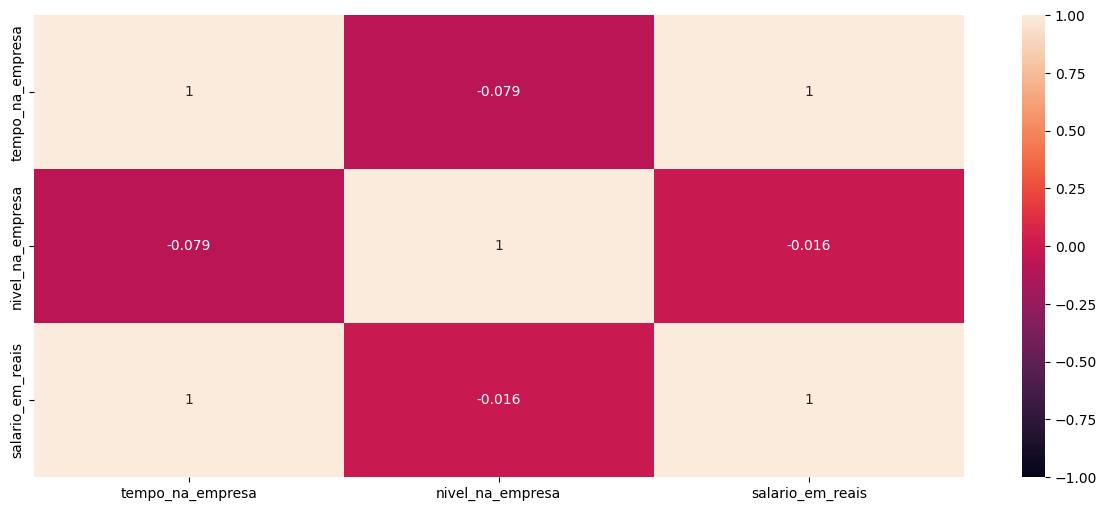

In [19]:
plt.figure(figsize=(15, 6))
sns.heatmap(df_salario_eda.corr('spearman'), vmin=-1, vmax=1, annot=True)

<Axes: >

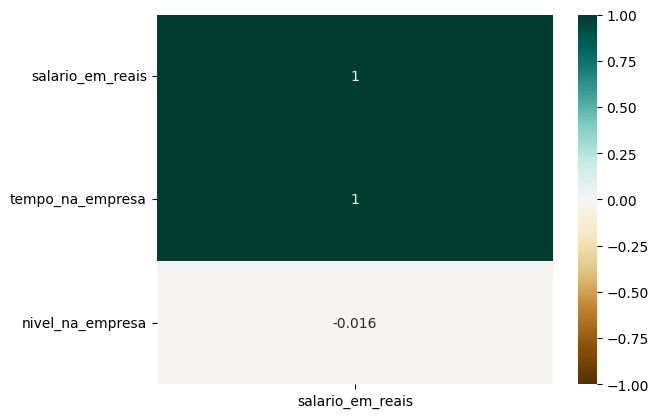

In [20]:
# Formato de ranking
sns.heatmap(df_salario_eda.corr('spearman')[['salario_em_reais']].sort_values(by='salario_em_reais', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

In [21]:
# Bucketing Tempo de Casa
bins_tempo_casa = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130]
labels_tempo_casa = ['0-19', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100-109', '110-119', '120-129']
df_salario_bucketing['escala_tempo'] = pd.cut(x=df_salario_bucketing['tempo_na_empresa'], bins=bins_tempo_casa, labels=labels_tempo_casa, include_lowest=True)

<Axes: xlabel='escala_tempo', ylabel='salario_em_reais'>

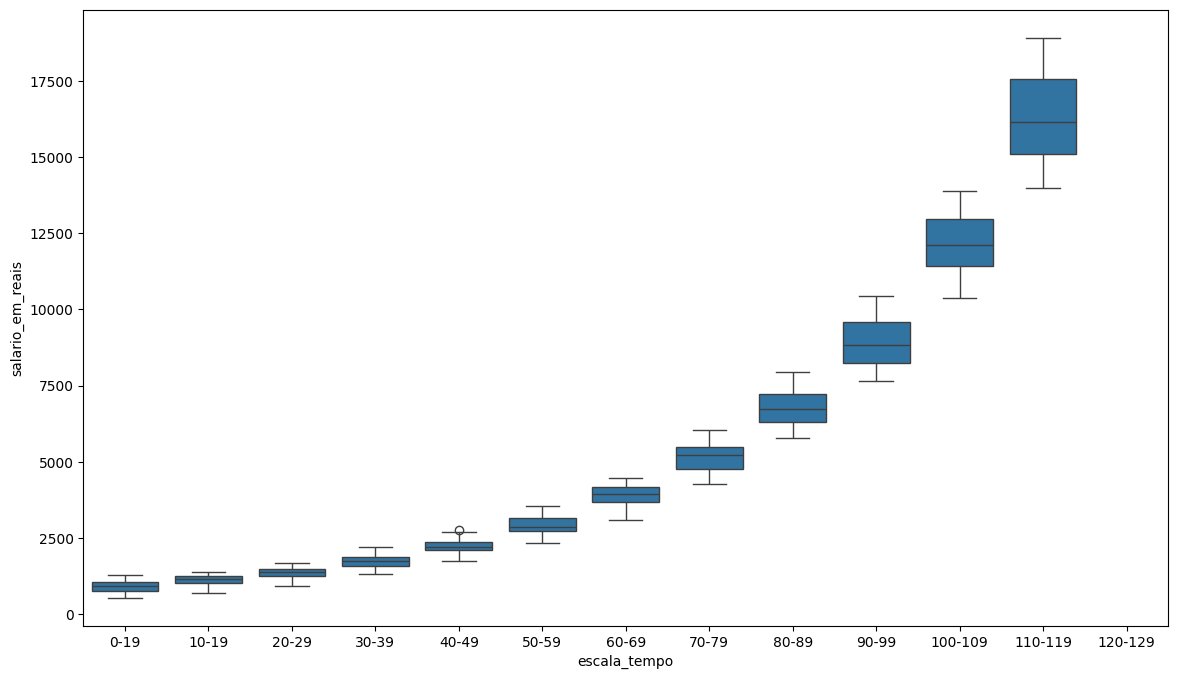

In [22]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_salario_bucketing, x='escala_tempo', y='salario_em_reais')

Treinar o modelo linear 

In [23]:
# Criar o dataset de treino de treino e teste
X = df_salario.drop(columns='salario_em_reais', axis=1)
y = df_salario['salario_em_reais']

In [24]:
# Split usando KFold com 5 pastas/splits
kf = KFold(n_splits=5, shuffle=True, random_state=51)

In [25]:
kf.split(X)

<generator object _BaseKFold.split at 0x0000014340CAB450>

In [26]:
# Bloco para Treinamento do modelo
colunas_numericas = ['tempo_na_empresa', 'nivel_na_empresa']

# Transformer numéricas
transformer_numericas = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Colunas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numericas, colunas_numericas)
    ]
)

# Criando o pipeline principal = Pré processor + Treinamento
model_regressao = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', LinearRegression())])

# Armazenar Treino e teste
rmse_scores_fold_train = []
rmse_scores_fold_test = []

# Armazenar R@ score Teste
r2scores_fold_test = []

# Armazenar Residuos
residuos = []

# Armazenar Predições
y_pred_total = []

for train_index, test_index in kf.split(X):
 X_train, X_test = X.iloc[train_index], X.iloc[test_index]
 y_train, y_test = y.iloc[train_index], y.iloc[test_index]
 
 # Treino o modelo no conjunto de treinamento
 model_regressao.fit(X_train, y_train)

 # Faça predições nos conjuntos de treinamento e teste
 y_train_pred = model_regressao.predict(X_train)
 y_test_pred = model_regressao.predict(X_test)

 # Calculo de RMSE para conjuntos de treinamento e teste
 rmse_train = root_mean_squared_error(y_train, y_train_pred)
 rmse_test = root_mean_squared_error(y_test, y_test_pred)
 r2score_test = r2_score(y_test, y_test_pred)
 residuos_test = np.array(y_test - y_test_pred)

 # armazena as métricas
 rmse_scores_fold_train.append(rmse_train)
 rmse_scores_fold_test.append(rmse_test)
 r2scores_fold_test.append(r2score_test)
 residuos.append(residuos_test)
 y_pred_total.append(y_test_pred)

rmse_train_final = np.mean(rmse_scores_fold_train)
rmse_test_final = np.mean(rmse_scores_fold_test)
r2scores_fold_final = np.mean(r2scores_fold_test)
percentual_rmse_final = (rmse_test_final - rmse_train_final) / rmse_train_final

# Concatenar predições de todos os folds
y_pred_total = np.concatenate(y_pred_total)

# Concatenar resíduos de todos os folds
residuos = np.concatenate(residuos)

# Padronizar resíduos
residuos_std = (residuos - residuos.mean()) / residuos.std()

Análise de métricas - Modelo Linear

In [27]:
# Metricas 
print(f'RMSE Treino: {rmse_train_final}')
print(f'RMSE Teste: {rmse_test_final}')
print(f'R2 Score Teste: {r2scores_fold_final}')
print(f'% Dif. RMSE Treino e Teste: {percentual_rmse_final}')

RMSE Treino: 1882.8318426651392
RMSE Teste: 1886.4504221336076
R2 Score Teste: 0.8261178870584761
% Dif. RMSE Treino e Teste: 0.0019218813844503052


Análise de residuos - modelo linear 

In [28]:
    """
    Transformar residuos na escaa padrão
    (X - média) / desvio padrão
    """
    residuos_std = zscore(residuos)

In [29]:
residuos_std

array([ 5.95616525e-01, -7.24916727e-01, -6.46846433e-01,  8.64095533e-01,
       -5.33806156e-02, -7.61704833e-01,  6.80947606e-01,  1.45661295e+00,
        3.15407488e-01, -5.85616590e-01,  1.29483240e-01,  8.62850152e-01,
       -8.81408422e-01, -2.57676835e-01, -3.98447700e-01,  4.84215194e-01,
       -9.30147928e-01, -1.98427398e-01,  2.09007896e-01, -9.04965560e-01,
       -6.81287606e-02, -8.34446292e-01, -3.95656924e-01,  1.85180868e-01,
       -8.59767063e-01, -1.16014546e+00, -9.89137623e-01,  1.98282340e+00,
       -7.09136535e-01, -5.86755306e-01,  2.97904569e+00,  3.41834809e-01,
       -1.07716414e+00,  1.30248304e+00, -5.99662310e-01, -4.35883427e-01,
       -5.78726106e-01, -1.02611646e+00,  3.62850210e-01,  1.01353539e+00,
       -3.51902591e-01,  9.50243614e-01,  1.10020428e+00,  3.93453210e-01,
       -8.28856918e-02, -2.86114598e-01, -1.14814701e+00, -7.64435745e-01,
       -2.96268121e-01, -9.37004031e-01, -5.80106334e-01,  4.60575328e-02,
       -2.64983022e-01,  

In [30]:
print(len(y_pred_total))
print(len(residuos_std))

1000
1000


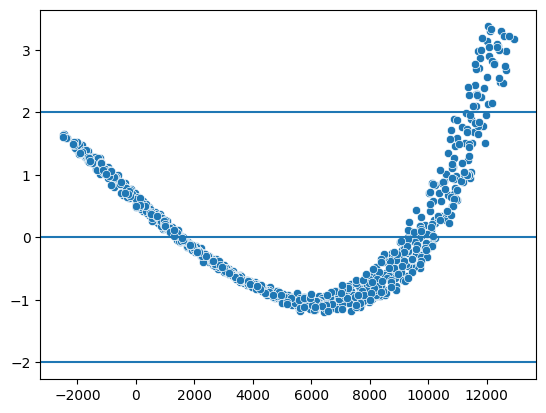

In [31]:
    """
    Verificar linearidade dos residuos: Valores entre -2 e 2 (Escala Padrão)
    Verificar homocedasticidade: Valores em torno da reta sem nenhuma tendencia ou formato
    """
    sns.scatterplot(x=y_pred_total, y=residuos_std)
    plt.axhline(y=0)
    plt.axhline(y=-2)
    plt.axhline(y=2)

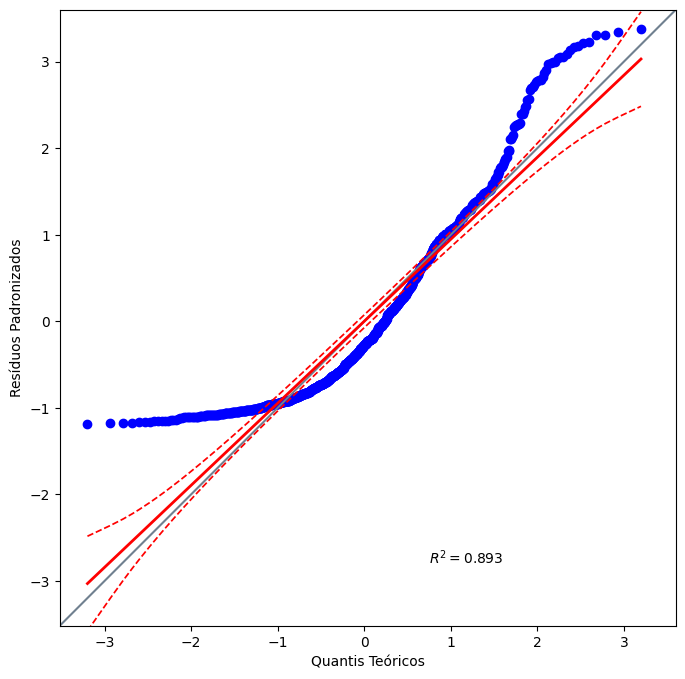

In [32]:
# Chegar se residuos seguem uma distribuição normal
plt.figure(figsize=(14, 8))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis Teóricos')
plt.ylabel('Resíduos Padronizados')
plt.show()

In [33]:
# teste de normalidade  shapiro Wilks
stat_shapiro, p_value_shapiro = shapiro(residuos)
print(f'Estat. Teste {stat_shapiro}, p-valor: {p_value_shapiro}')

Estat. Teste 0.891969217965228, p-valor: 7.013497918013492e-26


In [34]:
# teste de normalidade  Kolmogorov-Smirnov
stat_ks, p_value_ks = kstest(residuos, 'norm')
print(f'Estat. Teste {stat_ks}, p-valor: {p_value_ks}')

Estat. Teste 0.5939999999999955, p-valor: 0.0


In [35]:
# Teste de normalidade Lilliefors
stat_ll, p_value_ll = lilliefors(residuos, dist='norm', pvalmethod='table')
print(f'Estat. Teste {stat_ll}, p-valor: {p_value_ll}')

Estat. Teste 0.11825983774680088, p-valor: 0.0009999999999998899


Treinar modelo polinomial

In [36]:
# Exemplo de criação de Features Polinomiais 

feature_polynomial = PolynomialFeatures(degree=3, include_bias=False)

X_polynomial = feature_polynomial.fit_transform(X)
feature_polynomial.feature_names_in_

array(['tempo_na_empresa', 'nivel_na_empresa'], dtype=object)

In [37]:
feature_polynomial.get_feature_names_out(feature_polynomial.feature_names_in_)

array(['tempo_na_empresa', 'nivel_na_empresa', 'tempo_na_empresa^2',
       'tempo_na_empresa nivel_na_empresa', 'nivel_na_empresa^2',
       'tempo_na_empresa^3', 'tempo_na_empresa^2 nivel_na_empresa',
       'tempo_na_empresa nivel_na_empresa^2', 'nivel_na_empresa^3'],
      dtype=object)

In [38]:
# Bloco para Treinamento do Modelo
"""
 graus_polynominal = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] rodando o modelo, 
 descobrimos que o polinomio de grau 4 é a melhor opção para o nosso modelo, 
 pois apresenta um bom resultado de R2 Score e um percentual de diferença entre
 RMSE de treino e teste mais baixo, indicando que o modelo não está superajustado (overfitting) ou 
 subajustado (underfitting).
"""
graus_polynominal = [4]

rmse_train_values = []
rmse_test_values = []
percentual_rmse_values = []
r2score_test_values = []

# Split usando KFold com 5 pastas/splits

kf = KFold(n_splits=5, shuffle=True, random_state=51)

for grau in graus_polynominal:


    # Pipeline
    # Padronizar variáveis numéricas - tempo_na_empresa, nivel_na_empresa

    # Nomes das Colunas

    colunas_numericas = ['tempo_na_empresa', 'nivel_na_empresa']

    # Transformer para colunas numéricas
    transformer_numericas = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # Criar um ColumnTransformer

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', transformer_numericas, colunas_numericas)
        ]
    )

    # Criar Features Polinominais

    poly_feat = PolynomialFeatures(degree=grau, include_bias=False)

    # Criando o Pipeline principais = Pré-Processamento + Treinamento

    model_poly = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('poly_features', poly_feat),
            ('regressor', LinearRegression())
        ]
    )

    # Armazenar RMSE Treino e Teste

    rmse_scores_fold_train = []
    rmse_scores_fold_test = []

    # Armazenar R2 Score de Teste
    r2score_fold_test = []

    # Armazenar resíduos 

    residuos = []

    # Armazenar predições

    y_pred_total = []


    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Treine o modelo no conjunto de treinamento
        model_poly.fit(X_train, y_train)

        # Faça predições nos conjuntos de treinamentos e test
        y_train_pred = model_poly.predict(X_train)
        y_test_pred = model_poly.predict(X_test)

        # Calcule o RMSE, R2Score e Residuos para os conjuntos de treinamento
        rmse_train = root_mean_squared_error(y_train, y_train_pred)
        rmse_test = root_mean_squared_error(y_test, y_test_pred)

        # Calcule o R2Score e Residuos para conjunto de teste
        r2score_test = r2_score(y_test, y_test_pred)
        residuos_test = np.array(y_test - y_test_pred)

        # Armazena as métricas da iteração na lista
        rmse_scores_fold_train.append(rmse_train)
        rmse_scores_fold_test.append(rmse_test)
        r2score_fold_test.append(r2score_test)
        residuos.append(residuos_test)
        y_pred_total.append(y_test_pred)

    rmse_train_final = np.mean(rmse_scores_fold_train)
    rmse_test_final = np.mean(rmse_scores_fold_test)

    r2score_test_final = np.mean(r2score_fold_test)
    percentual_rmse_final = ((rmse_test_final - rmse_train_final) / rmse_train_final) * 100
    residuos = np.concatenate(residuos)
    y_pred_total = np.concatenate(y_pred_total)

    rmse_train_values.append(rmse_train_final)
    rmse_test_values.append(rmse_test_final)
    r2score_test_values.append(r2score_test_final)
    percentual_rmse_values.append(percentual_rmse_final) 

In [56]:
print(len(residuos))
print(len(y_pred_total))

1000
1000


In [40]:
print(type(rmse_test_values))
print(rmse_test_values)
print(len(graus_polynominal), len(rmse_test_values))

<class 'list'>
[54.70504352796304]
1 1


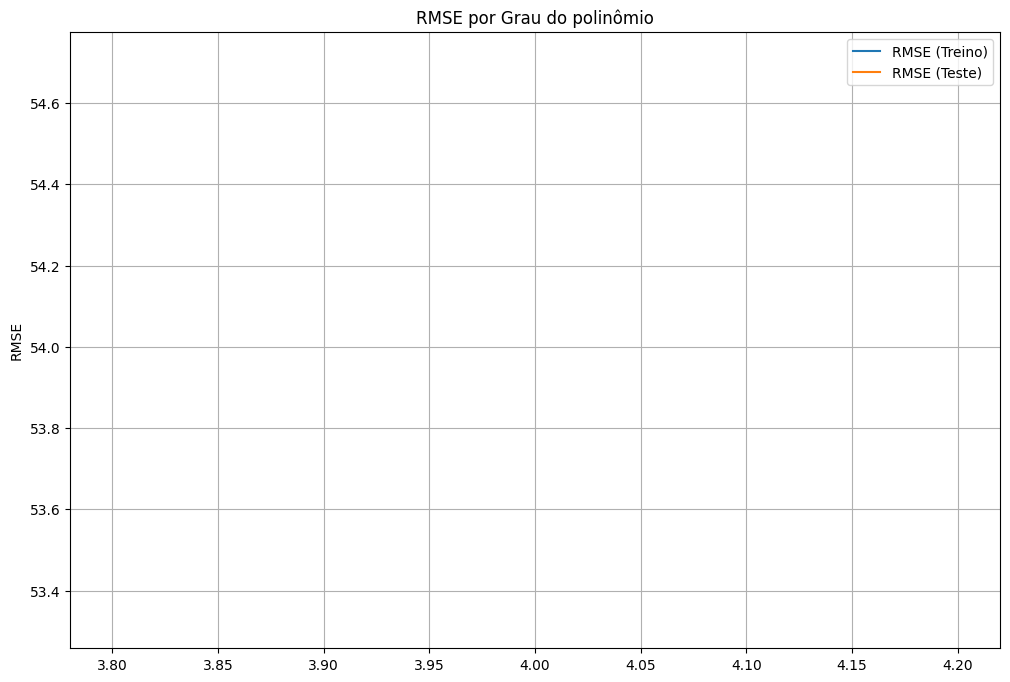

In [41]:

plt.figure(figsize=(12,8))
plt.plot(graus_polynominal, rmse_train_values, label='RMSE (Treino)')
plt.plot(graus_polynominal, rmse_test_values, label='RMSE (Teste)')
plt.ylabel('RMSE')
plt.title('RMSE por Grau do polinômio')
plt.legend()
plt.grid(True)
plt.show()

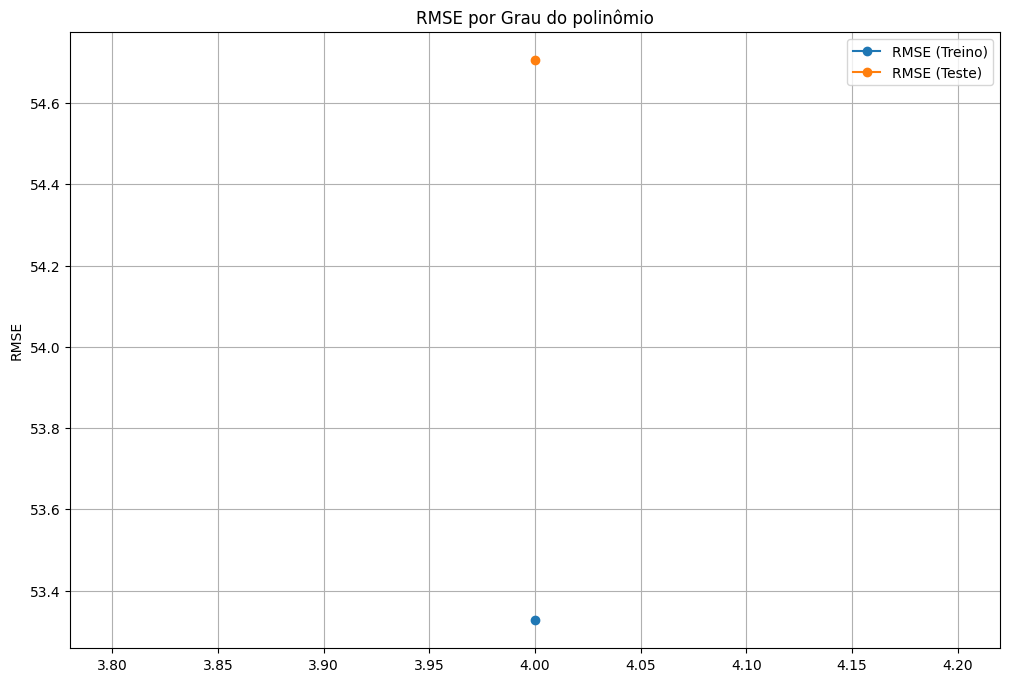

In [42]:
plt.figure(figsize=(12,8))
plt.plot(graus_polynominal, rmse_train_values, marker='o', label='RMSE (Treino)')
plt.plot(graus_polynominal, rmse_test_values, marker='o', label='RMSE (Teste)')
plt.ylabel('RMSE')
plt.title('RMSE por Grau do polinômio')
plt.legend()
plt.grid(True)
plt.show()

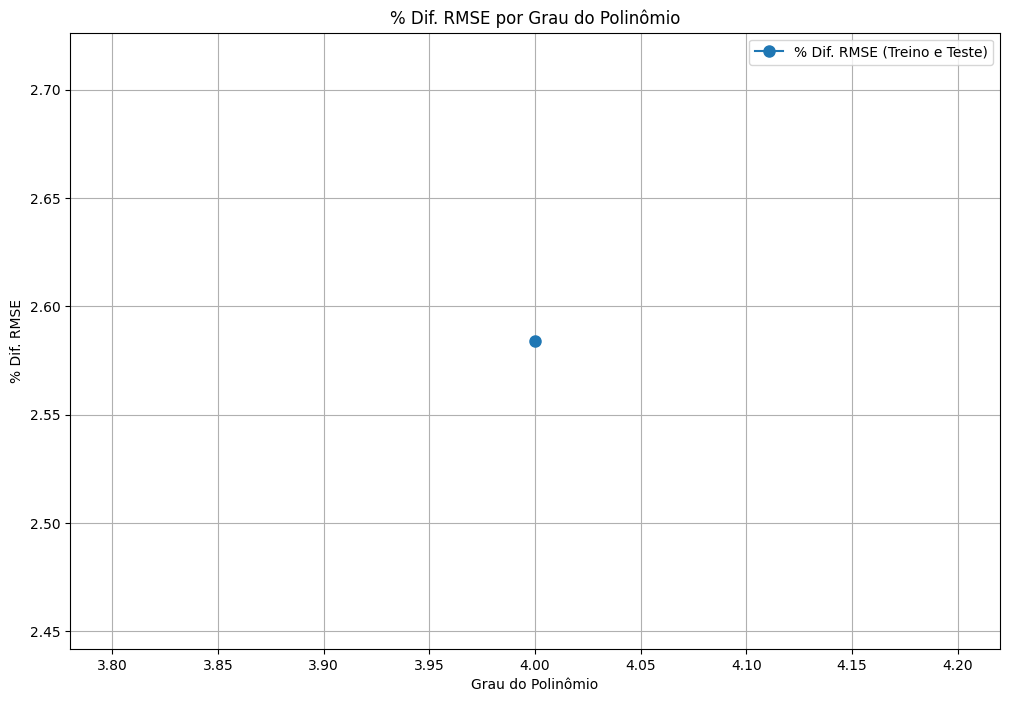

In [43]:
# Plotar gráfico para comparar %Dif RMSE (Treino e teste)

plt.figure(figsize=(12,8))
plt.plot(
    graus_polynominal,
    percentual_rmse_values,
    marker='o',
    markersize=8,
    label='% Dif. RMSE (Treino e Teste)'
)
plt.xlabel('Grau do Polinômio')
plt.ylabel('% Dif. RMSE')
plt.title('% Dif. RMSE por Grau do Polinômio')
plt.legend()
plt.grid(True)
plt.show()

Analise de métricas do modelo linear

In [44]:
# Métricas 
print(f'RMSE Treino: {rmse_train_final}')
print(f'RMSE Teste: {rmse_test_final}')
print(f'R2 Score Teste: {r2scores_fold_final}')
print(f'% Dif. RMSE Treino e Teste: {percentual_rmse_final}')

RMSE Treino: 53.32698559565161
RMSE Teste: 54.70504352796304
R2 Score Teste: 0.8261178870584761
% Dif. RMSE Treino e Teste: 2.5841661907546576


In [45]:
    """
    Transformar residuos na escaa padrão
    (X - média) / desvio padrão
    """
    residuos_std = zscore(residuos)

In [46]:
residuos_std

array([-1.76658136e+00,  6.13919903e-01,  4.57932407e-01,  3.77621549e-01,
       -1.77161928e+00, -2.13372467e+00, -2.88053498e-01, -1.15486201e+00,
        1.26076256e+00, -1.38932876e+00, -1.63659072e-01,  9.49916278e-01,
        1.10428797e+00, -1.69277005e+00, -1.55137077e+00,  6.50212053e-01,
        2.39650670e+00, -5.48674224e-01, -4.71815369e-01, -4.93214903e-01,
       -9.93275437e-01,  4.37069649e-01, -2.35827600e-01,  4.45720599e-01,
        1.40041227e-01, -2.28929917e+00,  3.58302195e-01,  6.15006495e-01,
        1.42514234e+00, -1.40851950e+00,  1.28177409e+00, -1.47234024e-01,
       -3.60957871e-01, -9.30096879e-02,  3.81531150e-01,  1.24092430e-01,
       -3.96949408e-01,  8.01984667e-01, -1.66729377e+00, -3.61968959e-01,
        1.09965292e+00,  4.53175371e-01, -3.37795185e-01, -6.12203426e-01,
        1.86697658e-01, -1.00712904e+00,  3.94042102e-01,  1.06437582e+00,
       -2.25733503e+00,  1.51520710e+00, -4.44535131e-01,  2.39420946e+00,
       -3.94795656e-01, -

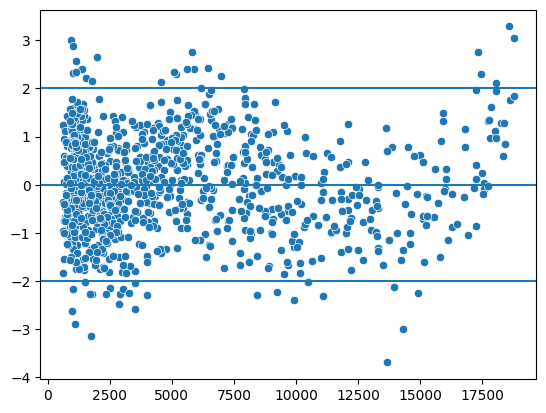

In [47]:
    """
    Verificar linearidade dos residuos: Valores entre -2 e 2 (Escala Padrão)
    Verificar homocedasticidade: Valores em torno da reta sem nenhuma tendencia ou formato
    """
    sns.scatterplot(x=y_pred_total, y=residuos_std)
    plt.axhline(y=0)
    plt.axhline(y=-2)
    plt.axhline(y=2)

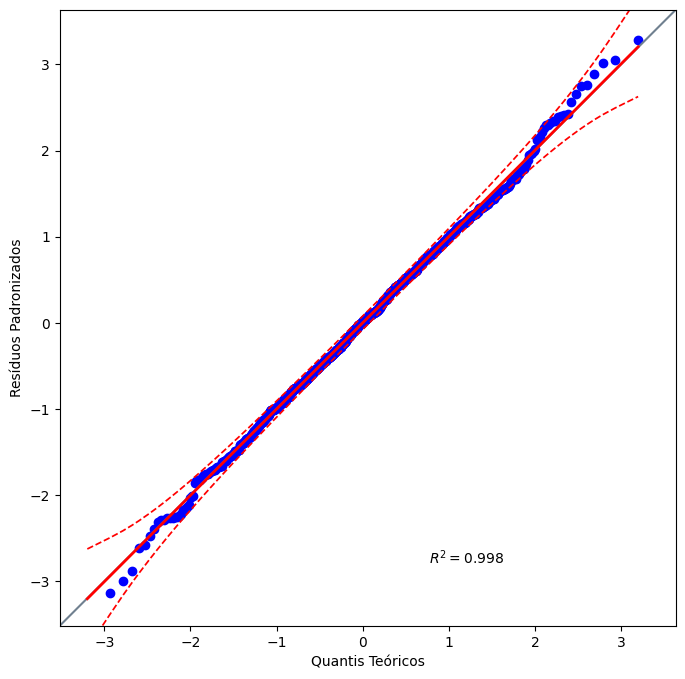

In [48]:
# Chegar se residuos seguem uma distribuição normal
plt.figure(figsize=(14, 8))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis Teóricos')
plt.ylabel('Resíduos Padronizados')
plt.show()

In [49]:
# teste de normalidade  shapiro Wilks
stat_shapiro, p_value_shapiro = shapiro(residuos)
print(f'Estat. Teste {stat_shapiro}, p-valor: {p_value_shapiro}')

Estat. Teste 0.9986951372205322, p-valor: 0.6852797159659514


In [50]:
# teste de normalidade  Kolmogorov-Smirnov
stat_ks, p_value_ks = kstest(residuos, 'norm')
print(f'Estat. Teste {stat_ks}, p-valor: {p_value_ks}')

Estat. Teste 0.48237446499530856, p-valor: 1.2202460106524514e-214


In [51]:
# Teste de normalidade Lilliefors
stat_ll, p_value_ll = lilliefors(residuos, dist='norm', pvalmethod='table')
print(f'Estat. Teste {stat_ll}, p-valor: {p_value_ll}')

Estat. Teste 0.013637346894986191, p-valor: 0.9566270022044506


In [52]:
# Teste de normalidade Lilliefors
stat_ll, p_value_ll = lilliefors(residuos, dist='norm', pvalmethod='table')
print(f'Estat. Teste {stat_ll}, p-valor: {p_value_ll}')

Estat. Teste 0.013637346894986191, p-valor: 0.9566270022044506


Realizar Predições Individuais

In [53]:
input_features = {
    'tempo_na_empresa': 80,
    'nivel_na_empresa': 10
}

pred_df = pd.DataFrame(input_features, index=[1])


In [54]:
# Predição Polinomial
model_poly.predict(pred_df)

array([5977.64164035])

In [55]:
# salvar modelo
joblib.dump(model_poly, './modelo_regressao_polinomial.pkl')

['./modelo_regressao_polinomial.pkl']